# Tutorial 4: Mode source

In this tutorial, we illustrate the usage and the importance of mode sources in integrated photonics simulations.

##  Setup

First we import Tidy3d and the other packages needed. If it is not installed, please do so with ``pip install tidy3d-beta``.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d.plugins import ModeSolver
from tidy3d import web

## Straight waveguide simulation

We will do a simulation of a straight waveguide, using a silicon ridge waveguide on a silicon oxide substrate. We begin by defining some general parameters.

In [2]:
# Unit length is micron.
wg_height = 0.25
wg_width = 0.5

# Permittivity of waveguide and substrate
si_eps = 3.48**2
sio_eps = 1.45**2

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
fwidth = freq0/10

# Simulation size inside the PML along propagation direction 
sim_length = 20 #um

# space between waveguide and PML
spacing = 1.5 #um

# Simulation domain size and total run time
sim_size = [sim_length, wg_width + spacing * 2, wg_height + spacing * 2]
run_time = 20/fwidth

# Grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lambda0)

# monitor and modal plane size
sz_plane = 2 #um

# Modal source position (x coordinate)
src_pos = -sim_size[0]/2 + spacing

## Create Simulation
Now we set up almost everything (structures, monitors, simulation) to run the example. Sources will be set up in the next section.

First, we define the substrate and the waveguide. Note that they both need to be extended into the PML layers. In `tidy3d`, the PML layers extend beyond the simulation domain (more details on setting up PML layers can be found [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq.html#how-do-i-add-pml-absorbing-boundaries-to-my-simulation)). So when defining the substrate and the waveguide, it is best to extend them well beyond the simulation domain size to make sure they truly extend into the PML layers.

In [3]:
# Waveguide and substrate materials
mat_wg = td.Medium(permittivity=si_eps)
mat_sub = td.Medium(permittivity=sio_eps)

# Substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sim_size[2]],
        size=[td.inf, td.inf, 2*sim_size[2]-wg_height],
    ),
    medium=mat_sub)

# Waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, wg_width, wg_height],
    ),
    medium=mat_wg)

Next, we define two types of monitors:
* `FieldMonitor` to visualize the fields in xy plane at central frequency;
* A set of `FluxMonitor` to measure the flux as a function of distance away from the source.

In [4]:
mnt_list = []

# xy-plane frequency-domain field monitor at central frequency
freq_mnt = td.FieldMonitor(
    center=[0, 0, 0],
    size=[np.inf, np.inf, 0],
    freqs=[freq0],
    name='field')
mnt_list.append(freq_mnt)

# A series of flux monitors
offset_from_source = 0.02 # the space between the 1st monitor and the source

pos_start = src_pos + offset_from_source # define the positions of the monitor
pos_end = sim_size[0]/2-spacing
num = 100
pos_list = np.linspace(pos_start,pos_end,num)

for i in range(num):
    flux_mnt = td.FluxMonitor(
        center= [pos_list[i], 0, 0],
        size=[0, sz_plane, sz_plane],
        freqs=[freq0],
        name='flux'+str(i),
    )
    
    mnt_list.append(flux_mnt)

Now it is time to define the simulation object.

In [5]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, waveguide],
    sources=[],
    monitors=mnt_list,
    run_time=run_time,
    pml_layers=3*[td.PML()])

[09:34:56] WARNING  No sources in simulation.                               ]8;id=158638;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=716082;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/components/simulation.py#388\388]8;;\

## Setup Source

In this waveguide example, we are interested in exciting a selected mode. This can be achieved with our in-built `Mode Source` feature (Detals can be found [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Modal_sources_monitors.html)). The procedue is as follows,

* First, we solve for eigenmodes with the in-built solver. The modes are computed at the central frequency of the source, and in order of decreasing effective index `n`, such that the modes that are fully below light-line (if any) should appear first.

In [6]:
# position and size of source plane
src_plane = td.Box(center=[src_pos, 0, 0], size=[0, sz_plane, sz_plane])

# number of modes to compute
num_modes = 2

# setup and solve for modes
mode_spec = td.ModeSpec(num_modes=num_modes)
ms = ModeSolver(simulation=sim, plane=src_plane, mode_spec=mode_spec, freqs=[freq0])
modes = ms.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

Effective index of computed modes:  [[2.56676581 2.00834226]]


* Next, we visualize the modes using the in-built plotting functions.

<Figure size 720x576 with 8 Axes>

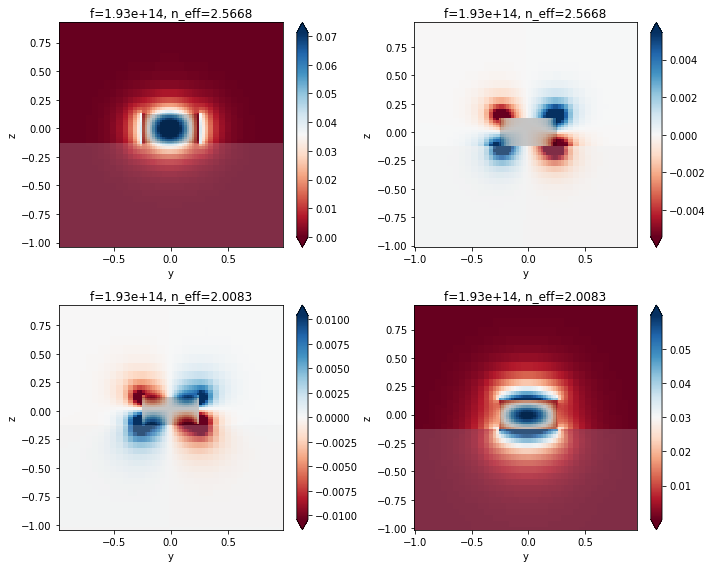

In [7]:
fig, axs = plt.subplots(num_modes, 2, figsize=(10, 8), tight_layout=True)
for mode_ind in range(num_modes):
    modes.plot_field("Ey", "real", freq=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    modes.plot_field("Ez", "real", freq=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])

* Finally, we select the mode to excite. In this example, we choose the fundamental TE mode, or Mode 0.

In [8]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_source = ms.to_source(mode_index=0, direction="+", source_time=source_time)
sim.sources = [mode_source]

As a comparison, here we setup another simulation whose source is simply a dipole source of the same polarization as the TE mode. We place the dipole source off the symmetry plane, since in general the waveguide might not have a symmetry plane.

In [9]:
point_source = td.PointDipole(
    center=(src_pos, wg_width/4, wg_height/4),
    source_time=source_time,
    polarization='Ey',
)
sim_point = sim.copy(deep=True)
sim_point.sources=[point_source]

## Visulization

Let's visualize the simulation with the modal source or the point source.

<Figure size 576x288 with 2 Axes>

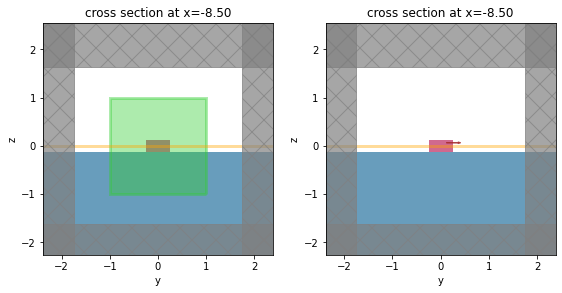

In [10]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim.plot(x=src_pos, ax=ax[0]);
sim_point.plot(x=src_pos, ax=ax[1]);

## Running simulation

We will submit the simulation to run as a new project.

In [11]:
sim_data = web.run(sim, task_name='waveguide_mode', path=f'data/sim_mode.hdf5')
sim_point_data = web.run(sim_point, task_name='waveguide_point', path=f'data/sim_point.hdf5')

[09:34:58] INFO     Using Tidy3D credentials from stored file                      ]8;id=504873;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/auth.py\auth.py]8;;\:]8;id=134395;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/auth.py#74\74]8;;\

[09:35:01] INFO     Uploaded task 'waveguide_mode' with task_id                 ]8;id=298296;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=501186;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#120\120]8;;\
                    '10897688-94bc-426b-9b00-77dbf260c4ba'.                                  

[09:35:03] INFO     Maximum flex unit cost: 0.20                                ]8;id=386922;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=499037;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#141\141]8;;\

Output()

[09:35:12] INFO     status = queued                                             ]8;id=562944;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=333839;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#263\263]8;;\

[09:35:32] INFO     starting up solver                                          ]8;id=126921;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=68175;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#267\267]8;;\

[09:35:49] INFO     running solver                                              ]8;id=227752;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=119918;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#272\272]8;;\

Output()

[09:36:08] INFO     early shutoff detected, exiting.                            ]8;id=214236;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=323870;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#282\282]8;;\

Output()

[09:36:12] INFO     status = postprocess                                        ]8;id=440635;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=612193;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#291\291]8;;\

[09:36:27] INFO     status = success                                            ]8;id=212244;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=221437;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#291\291]8;;\

[09:36:32] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=462103;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=375863;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sim_mode.hdf5"                                                     

Output()

[09:36:38] INFO     loading SimulationData from data/sim_mode.hdf5              ]8;id=764820;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=876083;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#357\357]8;;\

[09:36:41] INFO     Uploaded task 'waveguide_point' with task_id                ]8;id=476174;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=850097;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#120\120]8;;\
                    '9d752e1e-5a91-437d-ae7f-a6d16d289871'.                                  

[09:36:42] INFO     Maximum flex unit cost: 0.20                                ]8;id=124230;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=624168;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#141\141]8;;\

Output()

[09:36:51] INFO     status = queued                                             ]8;id=781949;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=115010;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#263\263]8;;\

[09:37:12] INFO     starting up solver                                          ]8;id=842713;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=346150;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#267\267]8;;\

[09:37:29] INFO     running solver                                              ]8;id=107435;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=289402;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#272\272]8;;\

Output()

[09:37:46] INFO     early shutoff detected, exiting.                            ]8;id=706681;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=199230;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#282\282]8;;\

Output()

[09:37:50] INFO     status = postprocess                                        ]8;id=934576;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=248530;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#291\291]8;;\

[09:38:06] INFO     status = success                                            ]8;id=338756;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=134568;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#291\291]8;;\

[09:38:11] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=436490;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=641701;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#522\522]8;;\
                    "data/sim_point.hdf5"                                                    

Output()

[09:38:16] INFO     loading SimulationData from data/sim_point.hdf5             ]8;id=920964;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=36591;file:///home/weiliang/miniconda3/envs/tidy3d/lib/python3.9/site-packages/tidy3d/web/webapi.py#357\357]8;;\

## Post Run Analysis

Once the simulation has completed, we can download the results and load them into the simulation object.

Now, Let's visulize the field xy plane at the central frequency

(-10.0, 0.0)

<Figure size 864x216 with 4 Axes>

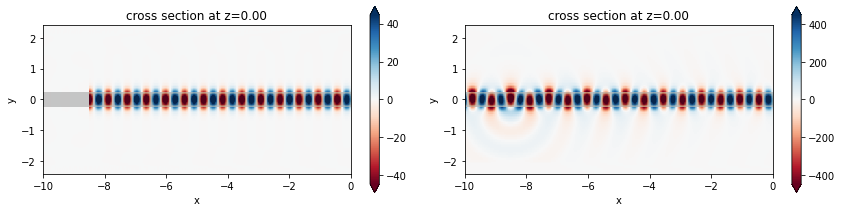

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12, 3), tight_layout=True)

sim_data.plot_field('field', 'Ey', z=0, freq=freq0, val='real', ax = ax[0])
sim_point_data.plot_field('field', 'Ey', z=0, freq=freq0, val='real', ax = ax[1])
ax[0].set_xlim([-10,0])
ax[1].set_xlim([-10,0])

The field excited by the modal source (left figure) shows sigle mode features; while the one by the point dipole (right figure) leaks to the free space. To quantatatively illustrate that, we plot the flux as a function of distance away from the source:

<matplotlib.legend.Legend object at 0x7f938263a910>

<Figure size 360x288 with 1 Axes>

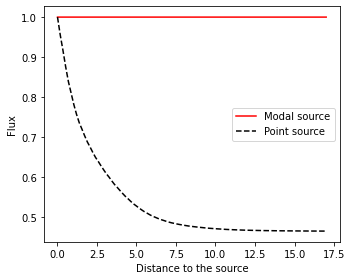

In [13]:
flux_list = np.zeros_like(pos_list)
flux_point_list = np.zeros_like(pos_list)
for i in range(num):
    flux_list[i] = sim_data['flux'+str(i)]
    flux_point_list[i] = sim_point_data['flux'+str(i)]

# normalize the dipole one
flux_point_list /= flux_point_list[0]

fig, ax = plt.subplots(1,figsize=(5, 4), tight_layout=True)
ax.plot(pos_list - src_pos, flux_list, '-r',label='Modal source')
ax.plot(pos_list - src_pos, flux_point_list, '--k', label='Point source')
ax.set_xlabel('Distance to the source')
ax.set_ylabel('Flux')
ax.legend()